In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import matplotlib.pyplot as plt
import inspect
import json

import re
from tqdm import tqdm
from konlpy.tag import Okt

inspect.getfile(plt)

'c:\\Users\\nbumk\\anaconda3\\envs\\mytf\\lib\\site-packages\\matplotlib\\pyplot.py'

In [241]:
## gpu driver 확인
# gpu = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], enable=True)
# print(gpu)

In [4]:
## Data 경로 설정
DATA_IN_PATH = './data_in/csv_short/'
DATA_OUT_PATH = './data_out/csv_short/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

## 파일 일기
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
## Random seed 설정
SEED_NUM = 1
tf.random.set_seed(SEED_NUM)

## 모델 변수값
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size'] # ['<PAD>\n', '<SOS>\n', '<END>\n', ... ,

print(char2idx) # {'<PAD>': 0, '<SOS>': 1, '<END>': 2, '<UNK>': 3,
print(idx2char) # {'0': '<PAD>', '1': '<SOS>', '2': '<END>', '3': '<UNK>', '4': '혼자인게', '5':  숫자 결과를 문장으로 변환할 때
print(std_index) # <SOS>
print(end_index) # <END>
print('vocab_size: ', vocab_size) # 111

{'<PAD>': 0, '<SOS>': 1, '<END>': 2, '<UNK>': 3, '구하셨나요': 4, '어서': 5, '평소에': 6, '바빠': 7, '잘생겼어': 8, '돌아가서': 9, '가스불': 10, '게': 11, '더': 12, '결단은': 13, '운동만': 14, '뭐하는지': 15, '마세요': 16, '좀': 17, '같아': 18, '나오세요': 19, '같아요': 20, '안': 21, '혼자를': 22, '나': 23, '적당히': 24, '다시': 25, '필요한': 26, '따뜻하게': 27, '너무': 28, '하세요': 29, '거예요': 30, '전생에': 31, '필요했던': 32, '자의': 33, '가상화폐': 34, '생각해보세요': 35, '켜놓고': 36, '켜고': 37, '따라': 38, '생일인데': 39, '집착하지': 40, '집에': 41, '데려가고': 42, '또': 43, '좋아요': 44, '좋다': 45, '달에는': 46, '즐기세요': 47, '열': 48, '끄고': 49, '식혀주세요': 50, '마음을': 51, '있어도': 52, '가끔': 53, '많이': 54, '때까지': 55, '훈훈해': 56, '오늘': 57, '그럴': 58, '뭘': 59, '가난한': 60, '운동을': 61, '돈은': 62, '좋을까': 63, '들어올': 64, '사세요': 65, '사람도': 66, '질린다': 67, '망함': 68, '선물로': 69, '뭐가': 70, '나온거': 71, '그': 72, '것': 73, '나갔어': 74, '거짓말': 75, '감기': 76, '쫄딱': 77, '땀난다': 78, '좋을': 79, '설득해보세요': 80, '싶어': 81, '궁금해': 82, '승진': 83, '보인다': 84, '믿어줘': 85, '땀을': 86, '다음': 87, '갔어': 88, '걸리겠어': 89, '줄까': 90, '설움': 91, '잊고': 92, '혼자인게

## Encoder

In [244]:
class Encoder(keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz # 2
        self.enc_units = enc_units # 1024
        self.vocab_size = vocab_size # 111
        self.embedding_dim = embedding_dim # 256
        self.embedding = keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = keras.layers.GRU(self.enc_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x) # x shape = (20, 25)
        # x shape = (20, 25, 256)
        _, state = self.gru(x, initial_state=hidden)
        # _ = (20, 25, 1024), state shape = (20, 1024)
        return state # TensorShape([20, 1024])
    
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units)) # inp shape = [20, 25], self.enc_units = 1024

In [245]:
################################# Code testing

# train_X = [[[0.1, 4.2, 1.5, 1.1, 2.8], 
#            [1.0, 3.1, 2.5, 0.7, 1.1], 
#            [0.3, 2.1, 1.5, 2.1, 0.1], 
#            [2.2, 1.4, 0.5, 0.9, 1.1]]]
# train_X = tf.convert_to_tensor(train_X, dtype=tf.float32)


# gru =  tf.keras.layers.GRU(units = 3, 
#                            return_sequences=True, 
#                            return_state=True)
# a, b = gru(train_X)
# print(a) # encoder time-step
# print(b)

In [246]:
## Encoder check
# enc_hidden_init = tf.random.normal((20, 1024))
# # vocab_size = 111, EMBEDDING_DIM = 256, UNITS = 1024, BATCH_SIZE = 2
# encoder = Encoder(vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE) 
# enc_hidden = encoder(index_inputs, enc_hidden_init )
# enc_hidden.shape

## Decoder

In [247]:
class Decoder(keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = keras.layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(self.vocab_size)
        
        
    def call(self, x, dec_hidden):
        x = self.embedding(x) #  x dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) shape =  (20, 1)
        # x shape = (20, 1, 256)
        
        output, state = self.gru(x, dec_hidden) # state = dec_hidden
        # output shape = (20, 1, 1024), state shape = (20, 1024)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        # x shape = (20, 111)
        
        return x, state, output

In [248]:
# decoder check
# dec_input = tf.dtypes.cast(tf.expand_dims(index_outputs[:, 0], 1), tf.float32)
# dec_hidden =  enc_hidden
# # print(dec_input.shape) # (20, 1)

# decoder = Decoder(vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
# x, stats, output = decoder(dec_input, dec_hidden)
# print('x =', x.shape)
# print('stats =', stats.shape)
# print('output =', output.shape)

## Loss Function

In [249]:
# optimizer = tf.keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction ='none')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='accuracy')
###########
# real = [1, 3]
# pred = [[0.05, 0.9, 0, 0.05], 
#           [0.1, 0.8, 0.05, 0.05]]
###########

def loss(real, pred): # real shape = (20, 25), pred shape = (20, 25, 111)
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # real 값이 0 이면 True => tf.math.logical_not => False
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

###########################################
# real = tf.convert_to_tensor([[2, 1, 0], 
#                              [1, 0, 0]])
# pred = tf.convert_to_tensor([[[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]],
#                              [[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]]])
###########################################

# real shape = (20, 25)
# pred shape = (20, 25, 111)
# def accuracy(real, pred):
#     mask = tf.math.logical_not(tf.math.equal(real, 0))
#     mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1) # mask tf.Tensor: shape=(20, 25)
#     # mask tf.Tensor: shape=(20, 25, 1)
#     pred *= mask
#     acc = train_accuracy(real, pred)
#     return tf.reduce_mean(acc)

In [250]:
## check loss

# loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction ='none')
# real = tf.convert_to_tensor([[2, 1, 0], 
#                              [1, 0, 0]])
# pred = tf.convert_to_tensor([[[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]],
#                              [[0.1, 0.6, 0.3], [0.05, 0.95, 0], [0.1, 0.6, 0.3]]])


# mask = tf.math.logical_not(tf.math.equal(real, 0)) # real 값이 0 이면 True => tf.math.logical_not => False
# print(mask)
# loss = loss_object(real, pred)
# print(loss)
# mask = tf.cast(mask, dtype=loss.dtype)
# loss *= mask
# print("loss *= mask", loss)
# tf.reduce_mean(loss)

## seq2seq 모델

In [251]:
# MODEL_NAME = 'seq2seq_kor'
# BATCH_SIZE = 2
# MAX_SEQUENCE = 25
# EPOCH = 30
# UNITS = 1024
# EMBEDDING_DIM = 256
# VALIDATION_SPLIT = 0.1
# vocab_size = 111 # ['<PAD>\n', '<SOS>\n', '<END>\n', ... 
# history = model.fit([index_inputs, index_outputs], index_targets,
#                     batch_size=BATCH_SIZE, epochs=EPOCH,
#                     validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

class seq2seq(keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, 
                 batch_sz, end_token_idx = 2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)
        
    def call(self, x):
        inp, tar = x # [index_inputs, index_outputs]
        
        end_hidden = self.encoder.initialize_hidden_state(inp) # 20 x 25 (sentence x MAX_SEQUENCE)
        # end_hidden =  zeros (20, 1024 (enc_units)) 
        enc_hidden = self.encoder(inp, end_hidden)  # enc_state (20, 1024) only last(hidden) state
        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]): # tar.shape = (20, 25 (MAX_LENGTH))
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) # tar[:, t].shape = (20,  )
            # dec_input shape = (20, 1)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden)
            # predictions shape = (20, 111), dec_hidden = (20, 1024)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
            # predict_tokens shape = (25, 20, 111)

        predicted = tf.stack(predict_tokens, axis=1) #   
        return predicted # tf.Tensor: shape=(20, 25, 111)
        
    def inference(self, x):
        inp = x
       
        enc_hidden_init = self.encoder.initialize_hidden_state(inp)
        # enc_hidden_init size = (, 1024)
        enc_hidden = self.encoder(inp, enc_hidden_init) 
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens =  list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden)
            predict_token = tf.argmax(predictions[0]) # predictions shape =  (1, 111)
            
            if predict_token == self.end_token_idx:
                break

            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)
            
        return tf.stack(predict_tokens, axis=0).numpy()
        

In [252]:
# decoder check
# x_tokens = list()
# for i in range(2):
#     dec_input = tf.dtypes.cast(tf.expand_dims(index_outputs[:, i], 1), tf.float32)
#     dec_hidden =  enc_hidden
#     # print(dec_input.shape) # (20, 1)

#     decoder = Decoder(vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE)
#     x, stats, output = decoder(dec_input, dec_hidden)
#     x_tokens.append(tf.dtypes.cast(x, tf.float32))

# print('x =', x.shape)
# print('x_tokens =', tf.convert_to_tensor(x_tokens).shape)
# print('stats =', stats.shape)
# print('output =', output.shape)
# predicted = tf.stack(x_tokens, axis=1)
# predicted.shape

In [253]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss = loss, optimizer=keras.optimizers.Adam(1e-3))

In [254]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'

cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10)
history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, 
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/30


9/9 [==============================] - ETA: 0s - loss: 0.9040
Epoch 1: val_loss improved from inf to 0.68762, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 26s 718ms/step - loss: 0.9040 - val_loss: 0.6876
Epoch 2/30
8/9 [=========================>....] - ETA: 0s - loss: 0.7506
Epoch 2: val_loss improved from 0.68762 to 0.55677, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 1s 68ms/step - loss: 0.7358 - val_loss: 0.5568
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.6395
Epoch 3: val_loss improved from 0.55677 to 0.55671, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 1s 68ms/step - loss: 0.6395 - val_loss: 0.5567
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.5882
Epoch 4: val_loss improved from 0.55671 to 0.49258, saving model to ./data_out/seq2seq_kor/weights.h5
9/9 [==============================] - 1s 66ms/step - l

In [255]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+ string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.ylim(0, 1)
    plt.legend([string, 'val_'+string])
    plt.show()

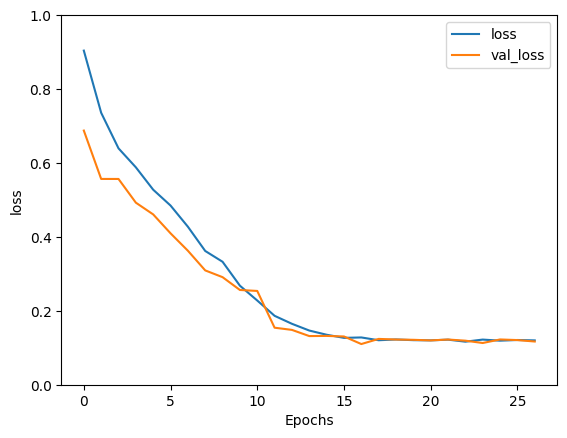

In [256]:
plot_graphs(history, 'loss')

## 결과 확인

In [257]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [258]:
FILTERS = "([~.,!?\"':;)(])"
CHANGE_FILTER = re.compile(FILTERS)


PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"


def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data

def enc_processing(value, dictionary, tokenize_as_morph=False):
    sequences_input_index = []
    sequences_length = []

    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)

        sequence_index = []
        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])

        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]

        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index), sequences_length

In [261]:
# query = "남자친구 승진 선물로 뭐가 좋을까?"

query = "평소에 필요했던 게 좋을 것 같아요"


test_index_inputs, _ = enc_processing([query], char2idx) 
print(test_index_inputs)

predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[[ 6 32 11 79 73 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
[99 41  9 49 19]
빨리 집에 돌아가서 끄고 나오세요
